<a href="https://colab.research.google.com/github/IzzyBrand/robotBottleFlip/blob/main/flip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forward kinematics of the gripper frame

Here is a simple example that let's you visualize the frames on the iiwa and the gripper.  If you click on the "Open Controls" menu in the MeshCat visualizer, and dig into the menu `meshcat->drake->Source` then you will see elements for each of the models in the `SceneGraph`: one for the iiwa, another for the WSG, and others for the clutter bins.  You can enable/disable their visualization.  Give it a spin!

In [ ]:
def gripper_forward_kinematics_example():
    builder = DiagramBuilder()

    # TODO: Replace this with a simple model directive of iiwa+wsg (no clutter bins)
    station = builder.AddSystem(ManipulationStation())
    station.SetupClutterClearingStation()
    station.Finalize()

    frames_to_draw = {"iiwa": {"iiwa_link_1", "iiwa_link_2", "iiwa_link_3", "iiwa_link_4", "iiwa_link_5", "iiwa_link_6", "iiwa_link_7"},
                      "gripper": {"body"}}
    meshcat = ConnectMeshcatVisualizer(builder,
        station.get_scene_graph(),
        output_port=station.GetOutputPort("pose_bundle"),
        zmq_url=zmq_url,
        frames_to_draw=frames_to_draw,
        axis_length=0.3,
        axis_radius=0.01)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()

    xyz = Text(value="", description="gripper position (m): ", layout=Layout(width='500px'), style={'description_width':'initial'})
    rpy = Text(value="", description="gripper roll-pitch-yaw (rad): ", layout=Layout(width='500px'), style={'description_width':'initial'})
    plant = station.get_multibody_plant()

    gripper = plant.GetBodyByName("body")
    def pose_callback(context):
        pose = plant.EvalBodyPoseInWorld(context, gripper)   ## This is the important line
        xyz.value = np.array2string(pose.translation(), formatter={'float': lambda x: "{:3.2f}".format(x)})
        rpy.value = np.array2string(RollPitchYaw(pose.rotation()).vector(), formatter={'float': lambda x: "{:3.2f}".format(x)})

    meshcat.load()
    MakeJointSlidersThatPublishOnCallback(station.get_multibody_plant(), meshcat, context, my_callback=pose_callback)
    display(xyz)
    display(rpy)

gripper_forward_kinematics_example()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://8d1a352a0057.ngrok.io/static/
Connected to meshcat-server.


FloatSlider(value=-1.57, description='iiwa_joint_1', layout=Layout(width="'200'"), max=2.96706, min=-2.96706, …

FloatSlider(value=0.1, description='iiwa_joint_2', layout=Layout(width="'200'"), max=2.0944, min=-2.0944, step…

FloatSlider(value=0.0, description='iiwa_joint_3', layout=Layout(width="'200'"), max=2.96706, min=-2.96706, st…

FloatSlider(value=-1.2, description='iiwa_joint_4', layout=Layout(width="'200'"), max=2.0944, min=-2.0944, ste…

FloatSlider(value=0.0, description='iiwa_joint_5', layout=Layout(width="'200'"), max=2.96706, min=-2.96706, st…

FloatSlider(value=1.6, description='iiwa_joint_6', layout=Layout(width="'200'"), max=2.0944, min=-2.0944, step…

FloatSlider(value=0.0, description='iiwa_joint_7', layout=Layout(width="'200'"), max=3.05433, min=-3.05433, st…

FloatSlider(value=-0.05, description='left_finger_sliding_joint', layout=Layout(width="'200'"), max=0.0, min=-…

FloatSlider(value=0.05, description='right_finger_sliding_joint', layout=Layout(width="'200'"), max=0.055, ste…

Text(value='[0.00 -0.47 0.66]', description='gripper position (m): ', layout=Layout(width='500px'), style=Desc…

Text(value='[-1.81 -0.00 0.00]', description='gripper roll-pitch-yaw (rad): ', layout=Layout(width='500px'), s…

# Kinematic Jacobians for pick and place

Let's set up the same iiwa + wsg example, with sliders (but without the frames), that we used above.  But this time I'll display the value of the Jacobian $J^G(q)$.

In [8]:
def pick_and_place_jacobians_example():
    builder = DiagramBuilder()

    # TODO: Replace this with a simple model directive of iiwa+wsg (no clutter bins)
    station = builder.AddSystem(ManipulationStation())
    station.SetupClutterClearingStation()
    station.Finalize()

    meshcat = ConnectMeshcatVisualizer(builder,
        station.get_scene_graph(),
        output_port=station.GetOutputPort("pose_bundle"),
#        delete_prefix_on_load=False,
        zmq_url=zmq_url)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()

    jacobian = Textarea(value="", description="J_G: ", layout={'width':'60%','height':'100px'}, style={'description_width':'initial'})
    sigma = Text(value="", description="smallest singular value(J_G): ", layout={'width':'60%'}, style={'description_width':'initial'})
    plant = station.get_multibody_plant()

    G = plant.GetBodyByName("body").body_frame()
    W = plant.world_frame()
    def pose_callback(context):
        J_G = plant.CalcJacobianSpatialVelocity(context, JacobianWrtVariable.kQDot, G, [0,0,0], W, W)   ## This is the important line
        jacobian.value = np.array2string(J_G, formatter={'float': lambda x: "{:5.1f}".format(x)})
        sigma.value = str(np.min(np.linalg.svd(J_G, compute_uv=False)))

    meshcat.load()

    # If you want to set the initial positions manually, use this:
    #plant.SetPositions(plant.GetMyContextFromRoot(context),
    #                   plant.GetModelInstanceByName("iiwa"),
    #                   [0, 0, 0, 0, 0, 0, 0])

    MakeJointSlidersThatPublishOnCallback(station.get_multibody_plant(), meshcat, context, my_callback=pose_callback)
    display(jacobian)
    display(sigma)

pick_and_place_jacobians_example()


Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://83cd5f813d39.ngrok.io/static/
Connected to meshcat-server.


FloatSlider(value=-1.57, description='iiwa_joint_1', layout=Layout(width="'200'"), max=2.96706, min=-2.96706, …

FloatSlider(value=0.1, description='iiwa_joint_2', layout=Layout(width="'200'"), max=2.0944, min=-2.0944, step…

FloatSlider(value=0.0, description='iiwa_joint_3', layout=Layout(width="'200'"), max=2.96706, min=-2.96706, st…

FloatSlider(value=-1.2, description='iiwa_joint_4', layout=Layout(width="'200'"), max=2.0944, min=-2.0944, ste…

FloatSlider(value=0.0, description='iiwa_joint_5', layout=Layout(width="'200'"), max=2.96706, min=-2.96706, st…

FloatSlider(value=1.6, description='iiwa_joint_6', layout=Layout(width="'200'"), max=2.0944, min=-2.0944, step…

FloatSlider(value=0.0, description='iiwa_joint_7', layout=Layout(width="'200'"), max=3.05433, min=-3.05433, st…

FloatSlider(value=-0.05, description='left_finger_sliding_joint', layout=Layout(width="'200'"), max=0.0, min=-…

FloatSlider(value=0.05, description='right_finger_sliding_joint', layout=Layout(width="'200'"), max=0.055, ste…

Textarea(value='[[  0.0   1.0   0.0  -1.0   0.0   1.0   0.0   0.0   0.0]\n [  0.0   0.0  -0.1  -0.0  -1.0   0.…

Text(value='0.17931039621645192', description='smallest singular value(J_G): ', layout=Layout(width='60%'), st…

# Our first end-effector "controller"

Let's use the pseudo-inverse of the Jacobian to drive the robot around.  To do that, we'll write a very simple system that looks at the current value of $q$, computes $[J^G]^+$, and uses it to command a constant spatial velocity, $V^G$.

We'll only run this controller for a short duration.  Constant spatial velocities aren't something that makes sense for a longer simulation!

Make sure you try changing $V^G$, and understand how the command relates to the motion of the robot.

In [9]:
# We can write a new System by deriving from the LeafSystem class.
# There is a little bit of boiler plate, but hopefully this example makes sense.
class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()
        self._W = plant.world_frame()

        self.DeclareVectorInputPort("iiwa_position", BasicVector(7))
        self.DeclareVectorOutputPort("iiwa_velocity", BasicVector(7), 
                                     self.CalcOutput)

    def CalcOutput(self, context, output):
        q = self.get_input_port().Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, JacobianWrtVariable.kQDot, 
            self._G, [0,0,0], self._W, self._W)
        J_G = J_G[:,0:7] # Ignore gripper terms
        
        V_G_desired = np.array([0,    # rotation about x
                                -.1,  # rotation about y
                                0,    # rotation about z
                                0,    # x
                                -.05, # y
                                -.1]) # z
        v = np.linalg.pinv(J_G).dot(V_G_desired)
        output.SetFromVector(v)

        
def jacobian_controller_example():
    builder = DiagramBuilder()

    station = builder.AddSystem(ManipulationStation())
    station.SetupClutterClearingStation()
    station.Finalize()

    controller = builder.AddSystem(PseudoInverseController(
        station.get_multibody_plant()))
    integrator = builder.AddSystem(Integrator(7))

    builder.Connect(controller.get_output_port(), 
                    integrator.get_input_port())
    builder.Connect(integrator.get_output_port(),
                    station.GetInputPort("iiwa_position"))
    builder.Connect(station.GetOutputPort("iiwa_position_measured"),
                    controller.get_input_port())

    meshcat = ConnectMeshcatVisualizer(builder,
        station.get_scene_graph(),
        output_port=station.GetOutputPort("pose_bundle"),
        zmq_url=zmq_url)

    diagram = builder.Build()
    simulator = Simulator(diagram)
    station_context = station.GetMyContextFromRoot(simulator.get_mutable_context())
    station.GetInputPort("iiwa_feedforward_torque").FixValue(station_context, np.zeros((7,1)))
    station.GetInputPort("wsg_position").FixValue(station_context, [0.1])
    # TODO(russt): Add this missing python binding
    #integrator.set_integral_value(
    #    integrator.GetMyContextFromRoot(simulator.get_mutable_context()), 
    #        station.GetIiwaPosition(station_context))
    integrator.GetMyContextFromRoot(simulator.get_mutable_context()).get_mutable_continuous_state_vector().SetFromVector(station.GetIiwaPosition(station_context))

    simulator.set_target_realtime_rate(1.0)
    simulator.AdvanceTo(0.01);

    return simulator

simulator = jacobian_controller_example()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://83cd5f813d39.ngrok.io/static/
Connected to meshcat-server.


In [ ]:
# Wait for the model to load in the visualizer, then run this cell to see the interesting part...
simulator.AdvanceTo(5.0 if running_as_notebook else 0.1);

# Compute grasp and pregrasp poses

Here is a simple example with a floating Schunk gripper and the foam brick.  It defines the grasp pose as described in the notes, and renders it to the 3D visualizer.

**Check yourself**: Try changing the grasp pose to our pregrasp pose.  Do you like the numbers that I picked in the text?

In [3]:
import numpy as np
import ipywidgets
import pydot
import os
from IPython.display import display, SVG

import importlib
import sys
from urllib.request import urlretrieve

if 'google.colab' in sys.modules and importlib.util.find_spec('manipulation') is None:
    urlretrieve(f"http://manipulation.csail.mit.edu/scripts/setup/setup_manipulation_colab.py",
                "setup_manipulation_colab.py")
    from setup_manipulation_colab import setup_manipulation
    setup_manipulation(manipulation_sha='master', drake_version='20201120', drake_build='nightly')

if 'google.colab' in sys.modules and os.getenv("DISPLAY") is None:
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

# Use pyngrok on colab.
server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']

# Start a single meshcat server instance to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)


import pydrake.all
from manipulation.scenarios import AddIiwa, AddWsg, AddRgbdSensors
from manipulation.utils import FindResource

def MakeManipulationStation(time_step=0.002):
    builder = pydrake.systems.framework.DiagramBuilder()

    # Add (only) the iiwa, WSG, and cameras to the scene.
    plant, scene_graph = pydrake.multibody.plant.AddMultibodyPlantSceneGraph(
        builder, time_step=time_step)
    iiwa = AddIiwa(plant)
    wsg = AddWsg(plant, iiwa)
    pydrake.multibody.parsing.Parser(plant).AddModelFromFile(
        FindResource("models/camera_box.sdf"), "camera0")
    plant.Finalize()

    num_iiwa_positions = plant.num_positions(iiwa)

    # I need a PassThrough system so that I can export the input port.
    iiwa_position = builder.AddSystem(pydrake.systems.primitives.PassThrough(num_iiwa_positions))
    builder.ExportInput(iiwa_position.get_input_port(), "iiwa_position")
    builder.ExportOutput(iiwa_position.get_output_port(), "iiwa_position_command")

    # Export the iiwa "state" outputs.
    demux = builder.AddSystem(pydrake.systems.primitives.Demultiplexer(
        2 * num_iiwa_positions, num_iiwa_positions))
    builder.Connect(plant.get_state_output_port(iiwa), demux.get_input_port())
    builder.ExportOutput(demux.get_output_port(0), "iiwa_position_measured")
    builder.ExportOutput(demux.get_output_port(1), "iiwa_velocity_estimated")
    builder.ExportOutput(plant.get_state_output_port(iiwa), "iiwa_state_estimated")

    # Make the plant for the iiwa controller to use.
    controller_plant = pydrake.multibody.plant.MultibodyPlant(time_step=time_step)
    controller_iiwa = AddIiwa(controller_plant)
    AddWsg(controller_plant, controller_iiwa, welded=True)
    controller_plant.Finalize()

    # Add the iiwa controller
    iiwa_controller = builder.AddSystem(
        pydrake.systems.controllers.InverseDynamicsController(
            controller_plant,
            kp=[100]*num_iiwa_positions,
            ki=[1]*num_iiwa_positions,
            kd=[20]*num_iiwa_positions,
            has_reference_acceleration=False))
    iiwa_controller.set_name("iiwa_controller")
    builder.Connect(
        plant.get_state_output_port(iiwa), iiwa_controller.get_input_port_estimated_state())

    # Add in the feed-forward torque
    adder = builder.AddSystem(pydrake.systems.primitives.Adder(2, num_iiwa_positions))
    builder.Connect(iiwa_controller.get_output_port_control(),
                    adder.get_input_port(0))
    # Use a PassThrough to make the port optional (it will provide zero values if not connected).
    torque_passthrough = builder.AddSystem(
        pydrake.systems.primitives.PassThrough([0]*num_iiwa_positions))
    builder.Connect(torque_passthrough.get_output_port(), adder.get_input_port(1))
    builder.ExportInput(torque_passthrough.get_input_port(), "iiwa_feedforward_torque")
    builder.Connect(adder.get_output_port(), plant.get_actuation_input_port(iiwa))

    # Add discrete derivative to command velocities.
    desired_state_from_position = builder.AddSystem(
        pydrake.systems.primitives.StateInterpolatorWithDiscreteDerivative(
            num_iiwa_positions, time_step, suppress_initial_transient=True))
    desired_state_from_position.set_name("desired_state_from_position")
    builder.Connect(desired_state_from_position.get_output_port(),      
                    iiwa_controller.get_input_port_desired_state())
    builder.Connect(iiwa_position.get_output_port(), desired_state_from_position.get_input_port())

    # Export commanded torques.
    #builder.ExportOutput(adder.get_output_port(), "iiwa_torque_commanded")
    #builder.ExportOutput(adder.get_output_port(), "iiwa_torque_measured")

    # Wsg controller.
    wsg_controller = builder.AddSystem(pydrake.manipulation.schunk_wsg.SchunkWsgPositionController())
    wsg_controller.set_name("wsg_controller")
    builder.Connect(wsg_controller.get_generalized_force_output_port(),             
                    plant.get_actuation_input_port(wsg))
    builder.Connect(plant.get_state_output_port(wsg), wsg_controller.get_state_input_port())
    builder.ExportInput(wsg_controller.get_desired_position_input_port(), "wsg_position")
    builder.ExportInput(wsg_controller.get_force_limit_input_port(), "wsg_force_limit")
    wsg_mbp_state_to_wsg_state = builder.AddSystem(
        pydrake.manipulation.schunk_wsg.MakeMultibodyStateToWsgStateSystem())
    builder.Connect(plant.get_state_output_port(wsg), wsg_mbp_state_to_wsg_state.get_input_port())
    builder.ExportOutput(wsg_mbp_state_to_wsg_state.get_output_port(), "wsg_state_measured")
    builder.ExportOutput(wsg_controller.get_grip_force_output_port(), "wsg_force_measured")

    # Cameras.
    AddRgbdSensors(builder, plant, scene_graph)

    # Export "cheat" ports.
    builder.ExportOutput(scene_graph.get_query_output_port(), "geometry_query")
    builder.ExportOutput(plant.get_contact_results_output_port(), "contact_results")
    builder.ExportOutput(plant.get_state_output_port(), "plant_continuous_state")

    diagram = builder.Build()
    return diagram

diagram = MakeManipulationStation()

Already on 'master'

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK

ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.5.3 which is incompatible.
ERROR: nbclient 0.5.1 has requirement jupyter-client>=6.1.5, but you'll have jupyter-client 5.3.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.






/opt/manipulation/manipulation/scenarios.py:197: DrakeDeprecationWarning: Constructs an RgbdSensor in the same way as the above overload, but
using the ``CameraProperties`` portion of ``properties`` for color
(and label) properties, and all of ``properties`` for depth
properties.  /
(Deprecated.)

Deprecated:
    CameraProperties are being deprecated. Please use the RenderCamera
    variant. This will be removed from Drake on or after 2021-03-01.
  show_window=False))
[2020-12-02 22:43:11.063] [console] [warning] RgbdSensor constructors that take 'CameraProperties' have been deprecated. Please use the RenderCamera variants instead.


In [5]:
def TestWithMeshcat():
    builder = pydrake.systems.framework.DiagramBuilder()
    station = builder.AddSystem(MakeManipulationStation())

    visualizer = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(
        builder, output_port=station.GetOutputPort("geometry_query"), zmq_url=zmq_url)

    diagram = builder.Build()

    context = diagram.CreateDefaultContext()
    visualizer.load(visualizer.GetMyContextFromRoot(context))
    diagram.Publish(context)

TestWithMeshcat()

/opt/manipulation/manipulation/scenarios.py:197: DrakeDeprecationWarning: Constructs an RgbdSensor in the same way as the above overload, but
using the ``CameraProperties`` portion of ``properties`` for color
(and label) properties, and all of ``properties`` for depth
properties.  /
(Deprecated.)

Deprecated:
    CameraProperties are being deprecated. Please use the RenderCamera
    variant. This will be removed from Drake on or after 2021-03-01.
  show_window=False))


Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://8065364df295.ngrok.io/static/
Connected to meshcat-server.


In [4]:
from google.colab import files

print('Please upload bottle.sdf')
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

bottle_sdf = uploaded['bottle.sdf'].decode("utf-8")

Please upload bottle.sdf


Saving bottle.sdf to bottle (1).sdf
User uploaded file "bottle.sdf" with length 2228 bytes


In [5]:
from pydrake.all import DirectCollocation, PiecewisePolynomial, Solve
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)
parser = Parser(plant, scene_graph)
bottle = parser.AddModelFromString(bottle_sdf, "sdf")

plant.Finalize()

context = plant.CreateDefaultContext()
dircol = DirectCollocation(
    plant,
    context,
    num_time_samples=21,
    minimum_timestep=0.1,
    maximum_timestep=0.4,
    input_port_index=plant.get_actuation_input_port().get_index())

dircol.AddEqualTimeIntervalsConstraints()

initial_state = (0., 0., h, 0., 0., 0.)
dircol.AddBoundingBoxConstraint(initial_state, initial_state,
                                dircol.initial_state())
# More elegant version is blocked by drake #8315:
# dircol.AddLinearConstraint(dircol.initial_state() == initial_state)

final_state_u = (0., -5., 0., 0., 0., -math.pi)
final_state_u = (10., 5., 0., 0., 0., math.pi)
dircol.AddBoundingBoxConstraint(final_state, final_state, dircol.final_state())

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [32]:
from pydrake.all import eq, MathematicalProgram, Solve, Variable
from pydrake.all import LinearSystem, DirectTranscription
import math
import matplotlib.pyplot as plt

prog = MathematicalProgram()

dt = 0.01;
g = 9.81
N = 50
vx0 = 10
vy0 = 10
h = 3

A = np.eye(12)
A[0, 3] = 1
A[1, 4] = 1
A[2, 5] = 1
A[6, 9] = 1
A[7, 10] = 1
A[8, 11] = 1
B = dt*np.array([[0, 0, 0, 0, 0, -g, 0, 0, 0, 0, 0, 0]]).T
C = np.eye(12)
D = np.zeros((12,1))

sys = LinearSystem(A, B, C, D, dt)

prog = DirectTranscription(sys, sys.CreateDefaultContext(), N)
#prog.AddBoundingBoxConstraint(x0, x0, prog.initial_state())
#prog.AddBoundingBoxConstraint(xf, xf, prog.final_state())
#prog.AddConstraintToAllKnotPoints(prog.input()[0] == 1)
#prog.AddConstraintToAllKnotPoints(prog.input()[0] == 1)

initial_state_l = (0., 0., h, -vx0, 0, 0, 0., 0., 0, -vx0, -vy0, 0.)
initial_state_u = (0., 5., 0., vx0, 0, 100, 0., 0., 0, vx0, vy0, 0.)

prog.AddBoundingBoxConstraint(initial_state_l, initial_state_u, prog.initial_state())

final_state_l = (0., -5., 0., -vx0, -vy0, -100, 0., 0., -math.pi, 0., 0., 0.)
final_state_u = (0., 5., 0., vx0, vy0, 0, 0., 0., math.pi, 0., 0., 0.)

prog.AddBoundingBoxConstraint(final_state_l, final_state_u, prog.final_state())

#prog.AddConstraint(state[timesteps, :] == xf)
# Do timestepping. Easy to do fixed timesteps with symplectic Euler, but timesteps can be decision variables as well. 
#for t in range(timesteps + 1):
#	prog.AddConstraint(x[t+1,:] = dynamics(x[t,:]) * h)

result = Solve(prog)
x_sol = prog.ReconstructStateTrajectory(result)
assert(result.is_success()), "Optimization failed"


plt.figure()
x_values = x_sol.vector_values(x_sol.get_segment_times())

plt.plot(x_values[0,:1], x_values[1,:1])
plt.xlabel('q')
plt.ylabel('qdot')

AssertionError: ignored

In [6]:
def grasp_poses_example():
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)
    parser = Parser(plant, scene_graph)
    grasp = parser.AddModelFromFile(FindResourceOrThrow(
        "drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"), "grasp")
    # TODO(russt): Draw the pregrasp gripper, too, as transparent (drake #13970).
    #pregrasp = parser.AddModelFromFile(FindResourceOrThrow(
    #    "drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"), "pregrasp")


    # NOTE(izzy): changed to load foam brick from local github repository
    # at https://github.com/IzzyBrand/robotBottleFlip so I commented this
    # out and replaced it with the request below
    #
    # brick = parser.AddModelFromFile(FindResourceOrThrow(
    #     "drake/examples/manipulation_station/models/061_foam_brick.sdf"))
    #

    # import requests
    # resp = requests.get("https://raw.githubusercontent.com/IzzyBrand/robotBottleFlip/main/models/061_foam_brick.sdf")
    # if resp.status_code == 200:
    #     brick_sdf = resp.text
    # brick = parser.AddModelFromString(brick_sdf, "sdf")

    brick = parser.AddModelFromString(bottle_sdf, "sdf")

    plant.Finalize()

    meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)

    # TODO(russt): Set a random pose of the object.

    # Get the current object, O, pose
    B_O = plant.GetBodyByName("base_link", brick)
    X_WO = plant.EvalBodyPoseInWorld(plant_context, B_O)

    B_Ggrasp = plant.GetBodyByName("body", grasp)
    p_GgraspO = [0, 0.12, 0]
    R_GgraspO = RotationMatrix.MakeXRotation(np.pi/2.0).multiply(
        RotationMatrix.MakeZRotation(np.pi/2.0))
    X_GgraspO = RigidTransform(R_GgraspO, p_GgraspO)
    X_OGgrasp = X_GgraspO.inverse()
    X_WGgrasp = X_WO.multiply(X_OGgrasp)

    plant.SetFreeBodyPose(plant_context, B_Ggrasp, X_WGgrasp)
    # Open the fingers, too.
    plant.GetJointByName("left_finger_sliding_joint", grasp).set_translation(plant_context, -0.054)
    plant.GetJointByName("right_finger_sliding_joint", grasp).set_translation(plant_context, 0.054)

    meshcat.load()
    diagram.Publish(context)

grasp_poses_example()

[2020-12-02 22:04:57.756] [console] [warning] Currently MultibodyPlant does not handle joint limits for continuous models. However some joints do specify limits. Consider setting a non-zero time step in the MultibodyPlant constructor; this will put MultibodyPlant in discrete-time mode, which does support joint limits.
[2020-12-02 22:04:57.757] [console] [warning] Joints that specify limits are: `left_finger_sliding_joint`, `right_finger_sliding_joint`.
[2020-12-02 22:04:57.775] [console] [warning] Currently MultibodyPlant does not handle joint limits for continuous models. However some joints do specify limits. Consider setting a non-zero time step in the MultibodyPlant constructor; this will put MultibodyPlant in discrete-time mode, which does support joint limits.
[2020-12-02 22:04:57.775] [console] [warning] Joints that specify limits are: `left_finger_sliding_joint`, `right_finger_sliding_joint`.


Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://98d2ba3c9b67.ngrok.io/static/
Connected to meshcat-server.


# A pick and place "sketch" with keyframes

Let's first define the canonical frames of our problem.  We've got a handful of them, and will pass them in and out of several functions, so I'll use a dictionary to store them.

*Edit*: I've added one more frame into the mix here, to get some clearance when moving between the bins.  Leaving it out gave my a nice [robot outtake](http://manipulation.csail.mit.edu/data/pick_fail.html), but we can do better.

In [ ]:
def make_gripper_frames(X_G, X_O):
  """
  Takes a partial specification with X_G["initial"] and X_O["initial"] and X_0["goal"], and 
  returns a X_G and times with all of the pick and place frames populated.
  """
  # Define (again) the gripper pose relative to the object when in grasp.
  p_GgraspO = [0, 0.12, 0]
  R_GgraspO = RotationMatrix.MakeXRotation(np.pi/2.0).multiply(
      RotationMatrix.MakeZRotation(np.pi/2.0))
  X_GgraspO = RigidTransform(R_GgraspO, p_GgraspO)
  X_OGgrasp = X_GgraspO.inverse()
  # pregrasp is negative y in the gripper frame (see the figure!).
  X_GgraspGpregrasp = RigidTransform([0, -0.08, 0])

  X_G["pick"] = X_O["initial"].multiply(X_OGgrasp)
  X_G["prepick"] = X_G["pick"].multiply(X_GgraspGpregrasp)
  X_G["place"] = X_O["goal"].multiply(X_OGgrasp)
  X_G["preplace"] = X_G["place"].multiply(X_GgraspGpregrasp)

  # I'll interpolate a ahlfway orientation by converting to axis angle and halving the angle.
  X_GprepickGpreplace = X_G["prepick"].inverse().multiply(X_G["preplace"])
  angle_axis = X_GprepickGpreplace.rotation().ToAngleAxis()
  X_GprepickGclearance = RigidTransform(AngleAxis(angle=angle_axis.angle()/2.0, axis=angle_axis.axis()), 
                                        X_GprepickGpreplace.translation()/2.0 + np.array([0, -0.3, 0]))
  X_G["clearance"] = X_G["prepick"].multiply(X_GprepickGclearance)

  # Now let's set the timing
  times = {"initial": 0}
  X_GinitialGprepick = X_G["initial"].inverse().multiply(X_G["prepick"])
  times["prepick"] = times["initial"] + 10.0*np.linalg.norm(X_GinitialGprepick.translation())
  # Allow some time for the gripper to close.
  times["pick_start"] = times["prepick"] + 2.0
  times["pick_end"] = times["pick_start"] + 2.0
  times["postpick"] = times["pick_end"] + 2.0
  time_to_from_clearance = 10.0*np.linalg.norm(X_GprepickGclearance.translation())
  times["clearance"] = times["postpick"] + time_to_from_clearance
  times["preplace"] = times["clearance"] + time_to_from_clearance
  times["place_start"] = times["preplace"] + 2.0
  times["place_end"] = times["place_start"] + 2.0
  times["postplace"] = times["place_end"] + 2.0

  return X_G, times

X_G = {"initial": RigidTransform(RotationMatrix.MakeXRotation(-np.pi/2.0), [0, -0.25, 0.25])}
X_O = {"initial": RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [-.2, -.75, 0.025]),
       "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi),[.75, 0, 0.025])}
X_G, times = make_gripper_frames(X_G, X_O)
print(f"Sanity check: The entire maneuver will take {times['postplace']} seconds to execute.")

Sanity check: The entire maneuver will take 30.900220749318255 seconds to execute.


Here's a simple visualization of those frames.  Use the controls menu in meshcat to view the different objects on the different "paths" to understand which objects belong to which frames.  Everything look reasonable?

Try changing the initial and final pose of the gripper / object.

In [ ]:
def visualize_gripper_frames(X_G, X_O):
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)
    parser = Parser(plant, scene_graph)
    gripper = FindResourceOrThrow(
        "drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf")
    brick = FindResourceOrThrow(
        "drake/examples/manipulation_station/models/061_foam_brick.sdf")

    for key, pose in X_G.items():
      g = parser.AddModelFromFile(gripper, f"gripper_{key}")
      plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("body", g), pose)
    for key, pose in X_O.items():
      o = parser.AddModelFromFile(brick, f"object_{key}")
      plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base_link", o), pose)

    plant.Finalize()


    meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)
    meshcat.load()

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

visualize_gripper_frames(X_G, X_O)

[2020-11-15 03:22:55.557] [console] [warning] Package "wsg_50_description" was found more than once in the search space.
[2020-11-15 03:22:55.630] [console] [warning] Package "wsg_50_description" was found more than once in the search space.
[2020-11-15 03:22:55.708] [console] [warning] Package "wsg_50_description" was found more than once in the search space.
[2020-11-15 03:22:55.783] [console] [warning] Package "wsg_50_description" was found more than once in the search space.
[2020-11-15 03:22:55.860] [console] [warning] Package "wsg_50_description" was found more than once in the search space.
[2020-11-15 03:22:56.062] [console] [warning] Currently MultibodyPlant does not handle joint limits for continuous models. However some joints do specify limits. Consider setting a non-zero time step in the MultibodyPlant constructor; this will put MultibodyPlant in discrete-time mode, which does support joint limits.
[2020-11-15 03:22:56.065] [console] [warning] Joints that specify limits ar

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://8e003a7c257b.ngrok.io/static/
Connected to meshcat-server.


# Pick and place trajectories

We've defined the keyframes, but now we will fill in timing details (what should be happening at each instant).  Interpolating between the positions is quite simple; we can encode these details as a `PiecewisePolynomial` trajectory in $\Re^3$ over time.

TODO(russt): Maybe implement `PiecewisePose` with an append workflow.

In [ ]:
def make_gripper_position_trajectory(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """
    # The syntax here is a little ugly; we need to pass in a matrix with the samples in the columns.
    # TODO(russt): Add python bindings for the std::vector constructor.
    traj = PiecewisePolynomial.FirstOrderHold(
        [times["initial"], times["prepick"]], np.vstack([X_G["initial"].translation(), X_G["prepick"].translation()]).T)

    # TODO(russt): I could make this less brittle if I was more careful on the names above, and just look up the pose for every time (in order)
    traj.AppendFirstOrderSegment(times["pick_start"], X_G["pick"].translation())
    traj.AppendFirstOrderSegment(times["pick_end"], X_G["pick"].translation())
    traj.AppendFirstOrderSegment(times["postpick"], X_G["prepick"].translation())
    traj.AppendFirstOrderSegment(times["clearance"], X_G["clearance"].translation())
    traj.AppendFirstOrderSegment(times["preplace"], X_G["preplace"].translation())
    traj.AppendFirstOrderSegment(times["place_start"], X_G["place"].translation())
    traj.AppendFirstOrderSegment(times["place_end"], X_G["place"].translation())
    traj.AppendFirstOrderSegment(times["postplace"], X_G["preplace"].translation())

    return traj

traj_p_G = make_gripper_position_trajectory(X_G, times)

Now let's plot our trajectories.  `Altair` is a plotting library built on Pandas and Vega-lite (to support interactive graphics), which works well in Colab.  I aim to start using it more.  

<sup><sub>TODO(russt): Add mouseover interaction that publishes to meshcat, so that a cursor on this plot renders the corresponding pose.(Unfortunately, I don't believe I can link a callback to python with altair).</sub></sup>

In [ ]:
data = dataframe(traj_p_G, traj_p_G.get_segment_times(), ['x','y','z'])
alt.vconcat(
  alt.Chart(data).mark_line().encode(x='t', y='x').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='y').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='z').properties(height=80),
)

alt.VConcatChart(...)

Unfortunately, Altair doesn't do 3D plotting (neither does mpld3), so here is the Plotly Express version.

In [ ]:
data = dataframe(traj_p_G, np.linspace(traj_p_G.start_time(), traj_p_G.end_time(), 50), ['x','y','z'])
fig = px.line_3d(data, x='x', y='y', z='z')
fig.update_traces(mode='lines+markers',
                  marker=dict(size=3, color="rgb(153, 51, 51)"),
                  line=dict(color="rgb(153, 51, 51)"))
if running_as_notebook:
    fig.show()

We also need to come up with a time trajectory for the orientations of our gripper.  Simple straight-line interpolation between rotations doesn't work particularly well, no matter how you are representing your rotations.  We'll use the quaternion "slerp" here (short for "spherical linear interpolation"), using the `PiecewiseQuaternionSlerp` trajectory class.

In [ ]:
def make_gripper_orientation_trajectory(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """
    traj = PiecewiseQuaternionSlerp();
    traj.Append(times["initial"], X_G["initial"].rotation())
    traj.Append(times["prepick"], X_G["prepick"].rotation())
    traj.Append(times["pick_start"], X_G["pick"].rotation())
    traj.Append(times["pick_end"], X_G["pick"].rotation())
    traj.Append(times["postpick"], X_G["prepick"].rotation())
    traj.Append(times["clearance"], X_G["clearance"].rotation())
    traj.Append(times["preplace"], X_G["preplace"].rotation())
    traj.Append(times["place_start"], X_G["place"].rotation())
    traj.Append(times["place_end"], X_G["place"].rotation())
    traj.Append(times["postplace"], X_G["preplace"].rotation())

    return traj

traj_R_G = make_gripper_orientation_trajectory(X_G, times)

We can plot the orientation trajectory, too.  Here are the components of the quaternion over time.

In [ ]:
data = dataframe(traj_R_G, traj_R_G.get_segment_times(), ['x','y','z','w'])
alt.vconcat(
  alt.Chart(data).mark_line().encode(x='t', y='x').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='y').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='z').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='w').properties(height=80)
)

alt.VConcatChart(...)

Better, I think, to just plot the entire result.  Before we do, let's quickly define the finger trajectory.

In [ ]:
opened = np.array([0.107]);
closed = np.array([0.0]);

def make_wsg_command_trajectory(times):
    traj_wsg_command = PiecewisePolynomial.FirstOrderHold(
        [times["initial"], times["pick_start"]], np.hstack([[opened], [opened]]))
    traj_wsg_command.AppendFirstOrderSegment(times["pick_end"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_start"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_end"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["postplace"], opened)
    return traj_wsg_command

traj_wsg_command = make_wsg_command_trajectory(times)

In [ ]:
data = dataframe(traj_wsg_command, traj_wsg_command.get_segment_times(), ['wsg'])
alt.Chart(data).mark_line().encode(x='t', y='wsg').properties(height=80)

alt.Chart(...)

Now let's really visualize the trajectory.  The best way is to animate it in 3D!  Please forgive the messiness of this particular bit of code; I'm trying to provide some intermediate steps that aren't typically used by the main drake developers.

TODO(russt): make this less "bespoke".

In [ ]:
class GripperTrajectoriesToPosition(LeafSystem):
    def __init__(self, plant, traj_p_G, traj_R_G, traj_wsg_command):
        LeafSystem.__init__(self)
        self.plant = plant
        self.gripper_body = plant.GetBodyByName("body")
        self.left_finger_joint = plant.GetJointByName("left_finger_sliding_joint")
        self.right_finger_joint = plant.GetJointByName("right_finger_sliding_joint")
        self.traj_p_G = traj_p_G
        self.traj_R_G = traj_R_G
        self.traj_wsg_command = traj_wsg_command
        self.plant_context = plant.CreateDefaultContext()

        self.DeclareVectorOutputPort("position", 
                                     BasicVector(plant.num_positions()),
                                     self.CalcPositionOutput)

    def CalcPositionOutput(self, context, output):
        t = context.get_time()
        X_G = RigidTransform(Quaternion(self.traj_R_G.value(t)), self.traj_p_G.value(t))
        self.plant.SetFreeBodyPose(self.plant_context, self.gripper_body, X_G)
        wsg = self.traj_wsg_command.value(t)
        self.left_finger_joint.set_translation(self.plant_context, -wsg/2.0)
        self.right_finger_joint.set_translation(self.plant_context, wsg/2.0)
        output.SetFromVector(self.plant.GetPositions(self.plant_context))

def visualize_pick_and_place_trajectory(traj_p_G, traj_R_G, traj_wsg_command, X_O):
    builder = DiagramBuilder()

    # Note: Don't use AddMultibodyPlantSceneGraph because we are only using
    # MultibodyPlant for parsing, then wiring directly to SceneGraph.
    scene_graph = builder.AddSystem(SceneGraph())
    plant = MultibodyPlant(time_step=0.0)
    plant.RegisterAsSourceForSceneGraph(scene_graph)
    parser = Parser(plant, scene_graph)
    gripper = parser.AddModelFromFile(FindResourceOrThrow(
        "drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"), "gripper")
    brick = FindResourceOrThrow(
        "drake/examples/manipulation_station/models/061_foam_brick.sdf")
    for key, pose in X_O.items():
      o = parser.AddModelFromFile(brick, f"object_{key}")
      plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base_link", o), pose)
    plant.Finalize()

    to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant))
    builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(plant.get_source_id()))

    traj_to_position = builder.AddSystem(GripperTrajectoriesToPosition(plant, traj_p_G, traj_R_G, traj_wsg_command))
    builder.Connect(traj_to_position.get_output_port(), to_pose.get_input_port())

    meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)

    diagram = builder.Build()

    simulator = Simulator(diagram)
    meshcat.start_recording()
    simulator.AdvanceTo(traj_p_G.end_time() if running_as_notebook else 0.1)
    meshcat.publish_recording()

visualize_pick_and_place_trajectory(traj_p_G, traj_R_G, traj_wsg_command, X_O)

[2020-11-15 03:22:58.101] [console] [warning] Currently MultibodyPlant does not handle joint limits for continuous models. However some joints do specify limits. Consider setting a non-zero time step in the MultibodyPlant constructor; this will put MultibodyPlant in discrete-time mode, which does support joint limits.
[2020-11-15 03:22:58.103] [console] [warning] Joints that specify limits are: `left_finger_sliding_joint`, `right_finger_sliding_joint`.


Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://8e003a7c257b.ngrok.io/static/
Connected to meshcat-server.


# Putting it all together

In the visualization above, we animated the plan, but did not actually command the robot!  Let's put our grasping trajectories back together with our Jacobian-based controller.

The first thing you might have noticed is that the Jacobian controller takes spatial velocities as input.  But so far we have trajectories for positions and orientations.  Let's differentiate them to get the velocities.

In [ ]:
traj_v_G = traj_p_G.MakeDerivative()
traj_w_G = traj_R_G.MakeDerivative()

data = dataframe(traj_v_G, np.linspace(traj_v_G.start_time(), traj_v_G.end_time()), ['x','y','z'])
alt.vconcat(
  alt.Chart(data).mark_line().encode(x='t', y='x').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='y').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='z').properties(height=80),
)

alt.VConcatChart(...)

Now we need a slightly modified version of our Jacobian controller, which can take the spatial velocity commands from an input port.

In [ ]:
# We can write a new System by deriving from the LeafSystem class.
# There is a little bit of boiler plate, but hopefully this example makes sense.
class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()
        self._W = plant.world_frame()

        self.w_G_port = self.DeclareVectorInputPort("omega_WG", BasicVector(3))
        self.v_G_port = self.DeclareVectorInputPort("v_WG", BasicVector(3))
        self.q_port = self.DeclareVectorInputPort("iiwa_position", BasicVector(7))
        self.DeclareVectorOutputPort("iiwa_velocity", BasicVector(7), 
                                     self.CalcOutput)
        # TODO(russt): Add missing binding
        #joint_indices = plant.GetJointIndices(self._iiwa)
        #self.position_start = plant.get_joint(joint_indices[0]).position_start()
        #self.position_end = plant.get_joint(joint_indices[-1]).position_start()
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()

    def CalcOutput(self, context, output):
        w_G = self.w_G_port.Eval(context)
        v_G = self.v_G_port.Eval(context)
        V_G = np.hstack([w_G, v_G])
        q = self.q_port.Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, JacobianWrtVariable.kV, 
            self._G, [0,0,0], self._W, self._W)
        J_G = J_G[:,self.iiwa_start:self.iiwa_end+1] # Only iiwa terms.
        v = np.linalg.pinv(J_G).dot(V_G)
        output.SetFromVector(v)

Oh, boy.  Big moment.  I'm excited... are you?  Let's do this thing!

In [ ]:
X_O = {"initial": RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [-.2, -.65, 0.09]),
       "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi),[.5, 0, 0.09])}

builder = DiagramBuilder()

station = builder.AddSystem(ManipulationStation())
station.SetupClutterClearingStation()
station.AddManipulandFromFile(
    "drake/examples/manipulation_station/models/061_foam_brick.sdf",
    X_O["initial"])
station.Finalize()

# Find the initial pose of the gripper (as set in the default Context)
temp_context = station.CreateDefaultContext()
plant = station.get_multibody_plant()
temp_plant_context = plant.GetMyContextFromRoot(temp_context)
X_G = {"initial": plant.EvalBodyPoseInWorld(temp_plant_context, plant.GetBodyByName("body"))}
X_G, times = make_gripper_frames(X_G, X_O)
print(f"Sanity check: The entire maneuver will take {times['postplace']} seconds to execute.")

# Make the trajectories
traj_p_G = make_gripper_position_trajectory(X_G, times)
traj_v_G = traj_p_G.MakeDerivative()
traj_R_G = make_gripper_orientation_trajectory(X_G, times)
traj_w_G = traj_R_G.MakeDerivative()

v_G_source = builder.AddSystem(TrajectorySource(traj_v_G))
v_G_source.set_name("v_WG")
w_G_source = builder.AddSystem(TrajectorySource(traj_w_G))
w_G_source.set_name("omega_WG")
controller = builder.AddSystem(PseudoInverseController(plant))
controller.set_name("PseudoInverseController")
builder.Connect(v_G_source.get_output_port(), controller.GetInputPort("v_WG"))
builder.Connect(w_G_source.get_output_port(), controller.GetInputPort("omega_WG"))

integrator = builder.AddSystem(Integrator(7))
integrator.set_name("integrator")
builder.Connect(controller.get_output_port(), 
                integrator.get_input_port())
builder.Connect(integrator.get_output_port(),
                station.GetInputPort("iiwa_position"))
builder.Connect(station.GetOutputPort("iiwa_position_measured"),
                controller.GetInputPort("iiwa_position"))

traj_wsg_command = make_wsg_command_trajectory(times)
wsg_source = builder.AddSystem(TrajectorySource(traj_wsg_command))
wsg_source.set_name("wsg_command")
builder.Connect(wsg_source.get_output_port(), station.GetInputPort("wsg_position"))

meshcat = ConnectMeshcatVisualizer(builder,
    station.get_scene_graph(),
    output_port=station.GetOutputPort("pose_bundle"),
#    delete_prefix_on_load=False,  # Use this if downloading is a pain.
    zmq_url=zmq_url,
)

diagram = builder.Build()
diagram.set_name("pick_and_place")

simulator = Simulator(diagram)
station_context = station.GetMyContextFromRoot(simulator.get_mutable_context())
# TODO(russt): Add this missing python binding
#integrator.set_integral_value(
#    integrator.GetMyContextFromRoot(simulator.get_mutable_context()), 
#        station.GetIiwaPosition(station_context))
integrator.GetMyContextFromRoot(simulator.get_mutable_context()).get_mutable_continuous_state_vector().SetFromVector(station.GetIiwaPosition(station_context))

simulator.set_target_realtime_rate(1.0)
meshcat.start_recording()
simulator.AdvanceTo(traj_p_G.end_time() if running_as_notebook else 0.1)
meshcat.stop_recording()
meshcat.publish_recording()


Sanity check: The entire maneuver will take 27.819595226260763 seconds to execute.
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://8e003a7c257b.ngrok.io/static/
Connected to meshcat-server.


That's quite some diagram we've assembled.  Do you understand all of the parts?

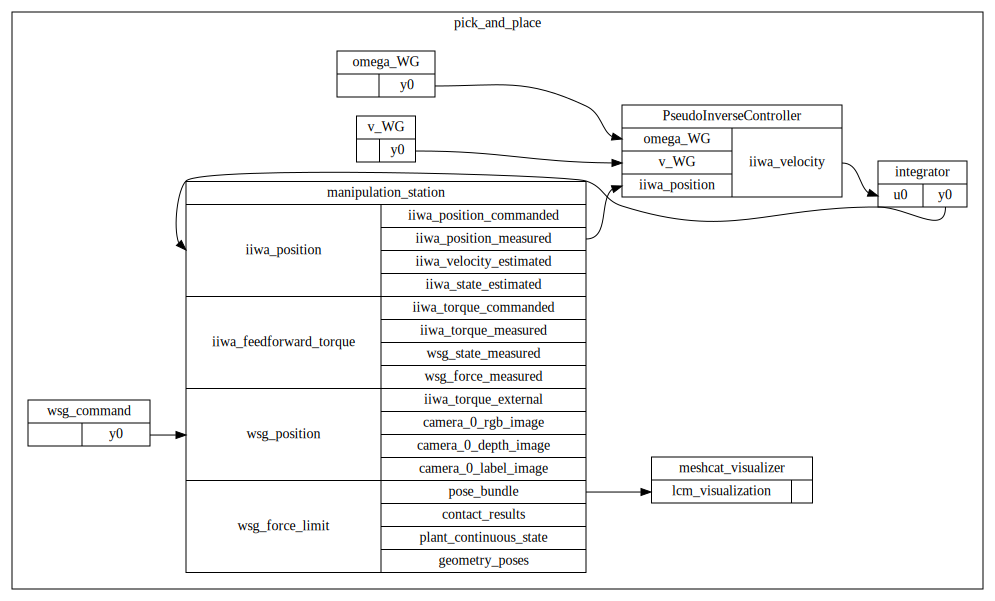

In [ ]:
SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=1))[0].create_svg())